<div class="alert alert-success">
<b>Reviewer's comment V2</b>

The project is accepted! Good luck on the final sprint!

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there is a problem with data splitting: now your data generator loads all data both for training and validation. It's pretty straightforward to fix though!

## Initialization

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
df = pd.read_csv("/datasets/faces/labels.csv")
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

### Check the dataset size

In [3]:
dataset_path = '/datasets/faces/final_files/'
file_count = len(os.listdir(dataset_path))

print(f"Number of files in the dataset: {file_count}")

Number of files in the dataset: 7591


### Age distribution

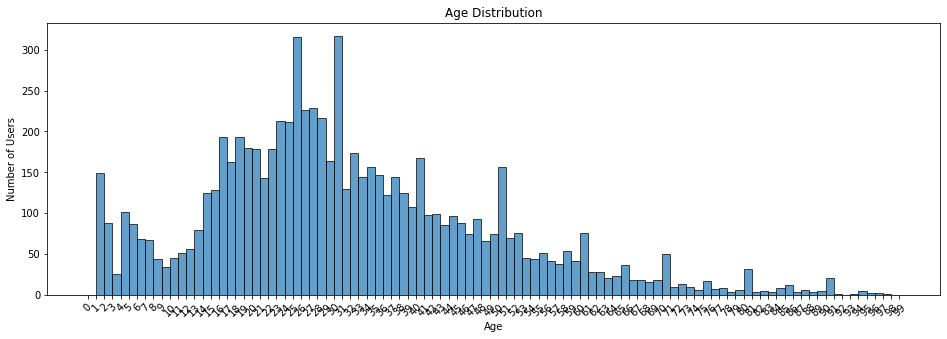

In [4]:
# Set the bins and range for age distribution
bins = range(0, 100, 1)  # Define bins with a step of 10
plt.figure(figsize=(16,5))
plt.hist(df['real_age'], bins=bins, edgecolor='k', alpha=0.7)

plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.title('Age Distribution')
plt.xticks(bins, rotation=45)

plt.show()

The whole age range shows a roughly bell shape. The main peak locates around 23 ~ 30, the sceondary peak is 1 year old to 6 years old. Finally, there are pulse values at every tens years old.

### Print photos

Found 7591 validated image filenames.


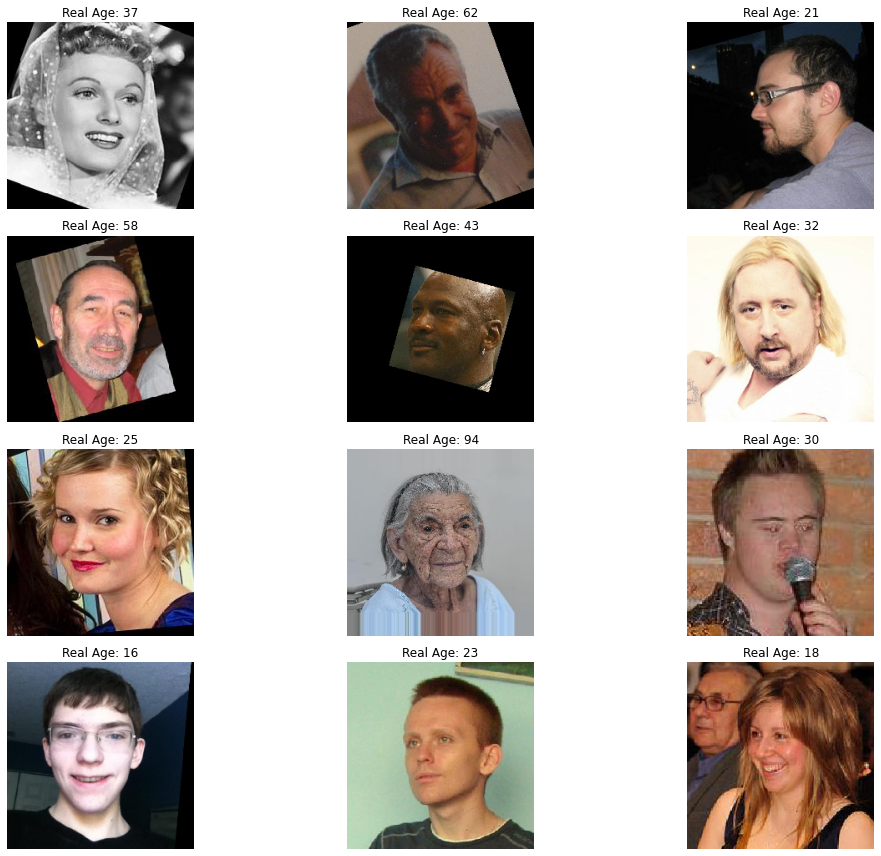

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
features, target = next(train_datagen_flow)
fig, axes = plt.subplots(4, 3, figsize=(16, 12))

# Flatten the axes array to access each subplot
axes = axes.flatten()

for i in range(12):
    # Display the image
    axes[i].imshow(features[i+12])
    axes[i].set_title(f'Real Age: {target[i+12]}')
    axes[i].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

### Findings

The quality of this dataset is not perfect for training, it's not easy to get high accurate result.

* Some pictures have already been augmented such as been rotated and stretched.
* Some pictures have a side of face while some of them have more than one face.
* The ground truth, real_age, is suspicious or ambiguous. 
    * Firstly, for a portrait photo, it's hard to tell the difference between adjacent ages, let's say for the picture of left bottom corner, you can't say it's wrong if the real age is 15 or 17. 
    * Secondly, the rate of aging varies for each individual person. For example, the model detects a set of features based on a 30-year-old reference, and it is applied to a well-maintained face, the predicted age might be younger than the actual age.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you checked target distribution and looked at some example images
    

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [6]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.25,
        horizontal_flip=True, rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            subset = 'training',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345) 

    return train_gen_flow

In [8]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            subset = 'validation',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345)

    return test_gen_flow

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

To make the data generator load train/validation subset you need to give `flow_from_dataframe()` method a `subset` parameter (`subset='training'` or `subset='validation'` respectively)

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Fixed!

</div>

In [9]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))    

    model.compile(
        optimizer=optimizer,
        loss='mae',
        metrics=['mae'],
    )

    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps,
        verbose=2,
        #shuffle=True,
    )

    return model

<div class="alert alert-success">
<b>Reviewer's comment</b>

The code for model creation and training is correct

</div>

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 178 steps, validate for 60 steps

Epoch 1/20
2023-08-13 13:42:24.709107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-13 13:42:25.537016: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 55s - loss: 11.1733 - mae: 11.1746 - val_loss: 22.5422 - val_mae: 22.5424

Epoch 2/20
178/178 - 38s - loss: 7.0879 - mae: 7.0882 - val_loss: 20.1111 - val_mae: 20.0802

Epoch 3/20
178/178 - 38s - loss: 6.2136 - mae: 6.2139 - val_loss: 11.9711 - val_mae: 11.9160

Epoch 4/20
178/178 - 38s - loss: 5.5034 - mae: 5.5037 - val_loss: 8.3449 - val_mae: 8.3483

Epoch 5/20
178/178 - 38s - loss: 4.9941 - mae: 4.9948 - val_loss: 7.1292 - val_mae: 7.1724

Epoch 6/20
178/178 - 38s - loss: 4.5808 - mae: 4.5809 - val_loss: 6.2219 - val_mae: 6.2547

Epoch 7/20
178/178 - 38s - loss: 4.2248 - mae: 4.2248 - val_loss: 6.3442 - val_mae: 6.3682

Epoch 8/20
178/178 - 38s - loss: 3.9445 - mae: 3.9446 - val_loss: 6.2554 - val_mae: 6.2533

Epoch 9/20
178/178 - 38s - loss: 3.7713 - mae: 3.7714 - val_loss: 6.3763 - val_mae: 6.3812

Epoch 10/20
178/178 - 38s - loss: 3.5614 - mae: 3.5615 - val_loss: 6.3256 - val_mae: 6.3351

Epoch 11/20
178/178 - 38s - loss: 3.3338 - mae: 3.3338 - val_loss: 5.9656 - val_mae: 5.9584

Epoch 12/20
178/178 - 38s - loss: 3.1376 - mae: 3.1379 - val_loss: 5.8054 - val_mae: 5.8019

Epoch 13/20
178/178 - 38s - loss: 2.9740 - mae: 2.9740 - val_loss: 6.1624 - val_mae: 6.1958

Epoch 14/20
178/178 - 38s - loss: 2.8526 - mae: 2.8531 - val_loss: 6.6521 - val_mae: 6.6741

Epoch 15/20
178/178 - 38s - loss: 2.7296 - mae: 2.7295 - val_loss: 5.7136 - val_mae: 5.7282

Epoch 16/20
178/178 - 38s - loss: 2.6681 - mae: 2.6681 - val_loss: 5.9481 - val_mae: 5.9478

Epoch 17/20
178/178 - 38s - loss: 2.6069 - mae: 2.6071 - val_loss: 5.8336 - val_mae: 5.8544

Epoch 18/20
178/178 - 38s - loss: 2.4710 - mae: 2.4711 - val_loss: 5.5944 - val_mae: 5.6209

Epoch 19/20
178/178 - 38s - loss: 2.3942 - mae: 2.3942 - val_loss: 5.7791 - val_mae: 5.7890

Epoch 20/20
178/178 - 38s - loss: 2.3274 - mae: 2.3271 - val_loss: 5.8241 - val_mae: 5.8478
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 5.8241 - mae: 5.8478

Test MAE: 5.8478

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Please retrain the model after fixing the problem with data split

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Good!
    

</div>

## Conclusions

I've implemented a ResNet50 model with the pretrained hyperparameters as the backbone, then added an average pooling layer plus a fully connection layer. Next I used the Adam optimizer and set the learning rate to 0.0001.

For the training process, after the 4th epoch, the MAE metric on the validation set was dramaticly improved from 22.54 to 8.35. When finished 20 epochs training, the MAE on the validation set was as low as 5.85. Finally the MAE score on the test set was 5.85 too, it met the project reqirement.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Please check the results after fixing the problem above

</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

There are actually no separate train and validation sets in this project: the 'test' MAE and 'validation' MAE are the same :)

</div>

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training